In [36]:
import pandas as pd

In [37]:
model_df = pd.read_csv("backtest_data/Final_Predicted_Prices.csv")
price_df = pd.read_csv("backtest_data/price_data.csv")
model_df.describe().T
model_df["Date"] = pd.to_datetime(model_df["Date"])
price_df.rename(columns={"DATE": "Date", "CLOSE.NEARBY": "Price"}, inplace=True)
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df.columns

Index(['Date', 'OPEN INTEREST', 'VOLUME', 'CONTRACT (YYYY/MM).NEARBY',
       'HIGH.NEARBY', 'LOW.NEARBY', 'Price', 'OPEN INTEREST.NEARBY',
       'VOLUME.NEARBY', 'CONTRACT (YYYY/MM).2', 'HIGH.2', 'LOW.2', 'CLOSE.2',
       'OPEN INTEREST.2', 'VOLUME.2', 'CONTRACT (YYYY/MM).3', 'HIGH.3',
       'LOW.3', 'CLOSE.3', 'OPEN INTEREST.3', 'VOLUME.3',
       'CONTRACT (YYYY/MM).4', 'HIGH.4', 'LOW.4', 'CLOSE.4', 'OPEN INTEREST.4',
       'VOLUME.4', 'CONTRACT (YYYY/MM).5', 'HIGH.5', 'LOW.5', 'CLOSE.5',
       'OPEN INTEREST.5', 'VOLUME.5', 'AVG IMPLIED VOLATILITY',
       '30-DAY HISTORICAL VOLATILITY'],
      dtype='object')

In [38]:
model_df = model_df.sort_values("Date")
price_df = price_df.sort_values("Date")

# Perform asof merge to match each model_df Date with the closest available price_df Date
merged_df = pd.merge_asof(model_df, price_df[['Date', 'Price']], on="Date", direction="nearest")

merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,119.0,87.235294,0.0,41.5,87.0,132.5,174.0,51.705605
Date,119,2017-05-07 16:08:04.033613568,2010-01-31 00:00:00,2013-07-15 12:00:00,2017-04-30 00:00:00,2021-02-14 00:00:00,2024-07-31 00:00:00,NaN
Total Production,119.0,177294.117647,63800.0,143700.0,172520.0,222674.0,285121.0,52813.672049
Year,119.0,2017.058824,2010.0,2013.0,2017.0,2021.0,2024.0,4.308632
Translated Predicted Production,119.0,988.648903,565.923338,863.522662,970.866999,1157.672962,1390.266015,196.712304
Beginning Stock,119.0,426.21018,189.255,363.638799,420.149811,524.189204,679.327003,122.025049
Total Predicted Supply,119.0,1414.859083,755.178338,1246.771309,1428.309663,1642.295006,1964.230194,294.338372
Actual Supply,119.0,1353.730923,892.751,1134.713317,1310.122464,1614.552928,1847.504179,295.20199
Predicted Demand,119.0,962.768799,672.973852,789.687657,886.842141,1153.074054,1334.059449,219.207758
Actual Demand,119.0,960.887348,710.8,785.93326,887.618927,1131.749115,1350.678226,201.944876


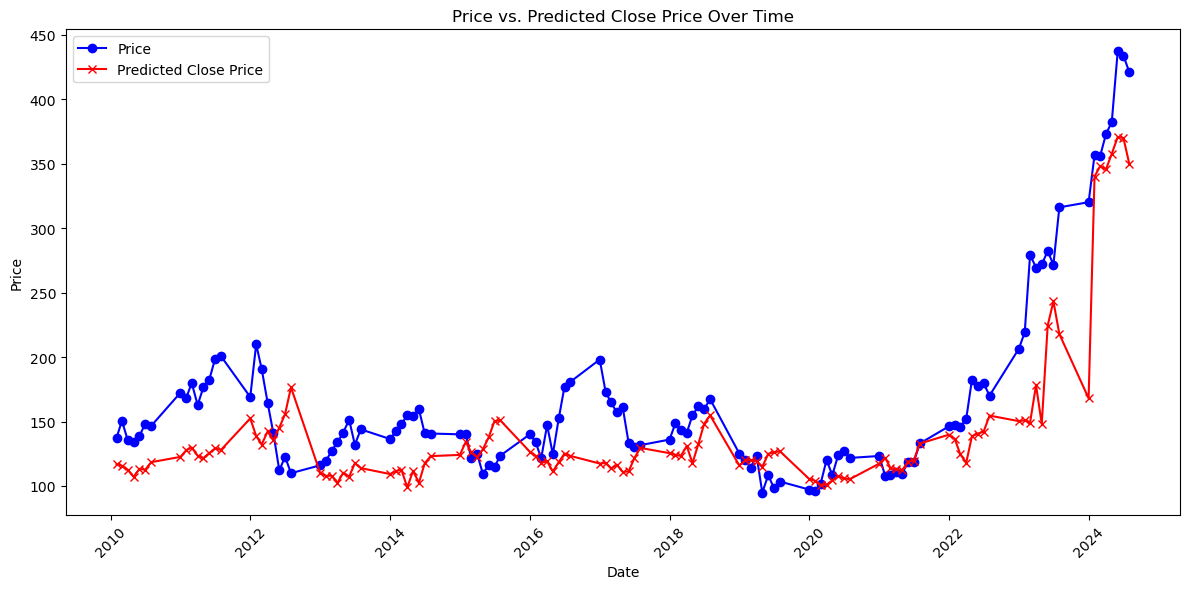

In [39]:
# Keep only the desired columns
merged_df = merged_df[['Date', 'Predicted Close Price', 'Price']]

import matplotlib.pyplot as plt

# Ensure Date is the datetime type (if not already)
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

plt.figure(figsize=(12, 6))

# Plot actual price
plt.plot(merged_df["Date"], merged_df["Price"], label="Price", color='blue', marker='o', linestyle='-')

# Plot predicted close price
plt.plot(merged_df["Date"], merged_df["Predicted Close Price"], label="Predicted Close Price", color='red', marker='x', linestyle='-')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price vs. Predicted Close Price Over Time")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()      # Adjust layout to prevent clipping of labels
plt.show()


In [40]:
# Simulate trading strategy:
# - Buy if predicted price >= current price * 1.20 (i.e. 20% over)
# - Stop-loss: sell if price falls to 90% of the entry price
# - Sell when actual price trails predicted price by 5% (i.e. actual price <= predicted price * 0.95)

trades = []  # To store trade details
in_trade = False
entry_price = None
entry_date = None

# Iterate through the DataFrame row by row
for idx, row in merged_df.iterrows():
    current_date = row['Date']
    actual_price = row['Price']
    predicted_price = row['Predicted Close Price']
    
    if not in_trade:
        # Check for buy signal:
        if predicted_price >= actual_price * 1.05:
            # Buy at the current day's actual price
            entry_price = actual_price
            entry_date = current_date
            in_trade = True
            print(f"BUY on {entry_date.date()} at {entry_price:.2f}")
    else:
        # We are in a trade. Define our exit conditions.
        stop_loss_threshold = entry_price * 0.90  # 10% below the entry price
        sell_condition_threshold = predicted_price * 0.95  # actual price trails predicted by 5%
        
        # Check stop-loss condition first
        if actual_price <= stop_loss_threshold:
            trades.append({
                "Buy Date": entry_date,
                "Buy Price": entry_price,
                "Sell Date": current_date,
                "Sell Price": actual_price,
                "Exit Reason": "Stop-loss"
            })
            print(f"SELL on {current_date.date()} at {actual_price:.2f} (Stop-loss triggered)")
            in_trade = False
            entry_price = None
            entry_date = None
        # Check sell condition: actual price trailing predicted price by 5%
        elif actual_price <= sell_condition_threshold:
            trades.append({
                "Buy Date": entry_date,
                "Buy Price": entry_price,
                "Sell Date": current_date,
                "Sell Price": actual_price,
                "Exit Reason": "Sell Condition"
            })
            print(f"SELL on {current_date.date()} at {actual_price:.2f} (Sell condition triggered)")
            in_trade = False
            entry_price = None
            entry_date = None

# Optional: if still in a trade at the end of the dataset, you can close the trade at the final day's price
if in_trade:
    last_row = merged_df.iloc[-1]
    trades.append({
        "Buy Date": entry_date,
        "Buy Price": entry_price,
        "Sell Date": last_row['Date'],
        "Sell Price": last_row['Price'],
        "Exit Reason": "End of Data"
    })
    print(f"SELL on {last_row['Date'].date()} at {last_row['Price']:.2f} (End of data)")

# Create a DataFrame of trades and display it
trades_df = pd.DataFrame(trades)
print("\nTrade Summary:")
print(trades_df)

# Optionally, save trades summary to CSV
trades_df.to_csv("backtest_data/trades_summary.csv", index=False)


BUY on 2012-05-31 at 112.05
SELL on 2012-06-30 at 122.65 (Sell condition triggered)
BUY on 2012-07-31 at 109.90
SELL on 2015-04-30 at 109.40 (Sell condition triggered)
BUY on 2015-05-31 at 116.30
SELL on 2015-06-30 at 114.90 (Sell condition triggered)
BUY on 2015-07-31 at 123.60
SELL on 2019-04-30 at 94.80 (Stop-loss triggered)
BUY on 2019-05-31 at 108.40
SELL on 2019-06-30 at 98.30 (Sell condition triggered)
BUY on 2019-07-31 at 103.45
SELL on 2019-12-31 at 97.20 (Sell condition triggered)
BUY on 2020-01-31 at 95.95
SELL on 2021-01-31 at 108.10 (Sell condition triggered)

Trade Summary:
    Buy Date  Buy Price  Sell Date  Sell Price     Exit Reason
0 2012-05-31     112.05 2012-06-30      122.65  Sell Condition
1 2012-07-31     109.90 2015-04-30      109.40  Sell Condition
2 2015-05-31     116.30 2015-06-30      114.90  Sell Condition
3 2015-07-31     123.60 2019-04-30       94.80       Stop-loss
4 2019-05-31     108.40 2019-06-30       98.30  Sell Condition
5 2019-07-31     103.45 201

In [41]:
# Calculate returns for each trade as a percentage change from the entry price
trades_df["Return"] = (trades_df["Sell Price"] - trades_df["Buy Price"]) / trades_df["Buy Price"]

# Calculate win percentage: percentage of trades with a positive return
win_percent = (trades_df["Return"] > 0).mean() * 100

# Calculate the Sharpe Ratio: mean(trade returns) / std(trade returns)
# Assuming risk-free rate is 0 for simplicity
mean_return = trades_df["Return"].mean()
std_return = trades_df["Return"].std()
sharpe_ratio = mean_return / std_return if std_return != 0 else float('nan')

print("Trade Summary:")
print(trades_df)
print("\nWin Percentage: {:.2f}%".format(win_percent))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))


Trade Summary:
    Buy Date  Buy Price  Sell Date  Sell Price     Exit Reason    Return
0 2012-05-31     112.05 2012-06-30      122.65  Sell Condition  0.094601
1 2012-07-31     109.90 2015-04-30      109.40  Sell Condition -0.004550
2 2015-05-31     116.30 2015-06-30      114.90  Sell Condition -0.012038
3 2015-07-31     123.60 2019-04-30       94.80       Stop-loss -0.233010
4 2019-05-31     108.40 2019-06-30       98.30  Sell Condition -0.093173
5 2019-07-31     103.45 2019-12-31       97.20  Sell Condition -0.060416
6 2020-01-31      95.95 2021-01-31      108.10  Sell Condition  0.126628

Win Percentage: 28.57%
Sharpe Ratio: -0.22


In [42]:
trades = []  # To store trade details
position = None  # None, "long", or "short"
entry_price = None
entry_date = None

for idx, row in merged_df.iterrows():
    current_date = row['Date']
    actual_price = row['Price']
    predicted_price = row['Predicted Close Price']
    
    if position is None:
        # Check for long entry: Buy when actual price is 10% below predicted
        if actual_price <= predicted_price * 0.90:
            position = "long"
            entry_price = actual_price
            entry_date = current_date
            print(f"LONG BUY on {entry_date.date()} at {entry_price:.2f}")
        
        # Check for short entry: Short when actual price is 10% above predicted
        elif actual_price >= predicted_price * 1.10:
            position = "short"
            entry_price = actual_price
            entry_date = current_date
            print(f"SHORT SELL on {entry_date.date()} at {entry_price:.2f}")
    
    else:
        if position == "long":
            # Long trade exit conditions
            stop_loss_threshold = entry_price * 0.95  # 5% below entry
            if actual_price <= stop_loss_threshold:
                trades.append({
                    "Trade Type": "Long",
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": current_date,
                    "Exit Price": actual_price,
                    "Exit Reason": "Stop-loss"
                })
                print(f"LONG EXIT on {current_date.date()} at {actual_price:.2f} (Stop-loss triggered)")
                position = None
                entry_price = None
                entry_date = None
            elif actual_price >= predicted_price:
                trades.append({
                    "Trade Type": "Long",
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": current_date,
                    "Exit Price": actual_price,
                    "Exit Reason": "Sell Signal"
                })
                print(f"LONG EXIT on {current_date.date()} at {actual_price:.2f} (Sell signal triggered)")
                position = None
                entry_price = None
                entry_date = None

        elif position == "short":
            # Short trade exit conditions
            stop_loss_threshold = entry_price * 1.05  # 5% above entry
            if actual_price >= stop_loss_threshold:
                trades.append({
                    "Trade Type": "Short",
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": current_date,
                    "Exit Price": actual_price,
                    "Exit Reason": "Stop-loss"
                })
                print(f"SHORT EXIT on {current_date.date()} at {actual_price:.2f} (Stop-loss triggered)")
                position = None
                entry_price = None
                entry_date = None
            elif actual_price <= predicted_price:
                trades.append({
                    "Trade Type": "Short",
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": current_date,
                    "Exit Price": actual_price,
                    "Exit Reason": "Cover Signal"
                })
                print(f"SHORT EXIT on {current_date.date()} at {actual_price:.2f} (Cover signal triggered)")
                position = None
                entry_price = None
                entry_date = None

# If still in a trade at the end of the dataset, close the trade at the final day's price.
if position is not None:
    last_row = merged_df.iloc[-1]
    exit_reason = "End of Data"
    trade_type = "Long" if position == "long" else "Short"
    trades.append({
        "Trade Type": trade_type,
        "Entry Date": entry_date,
        "Entry Price": entry_price,
        "Exit Date": last_row['Date'],
        "Exit Price": last_row['Price'],
        "Exit Reason": exit_reason
    })
    print(f"{trade_type.upper()} EXIT on {last_row['Date'].date()} at {last_row['Price']:.2f} (End of data)")

# Create a DataFrame of trades and display it
trades_df = pd.DataFrame(trades)
print("\nTrade Summary:")
print(trades_df)

# Optionally, save trades summary to CSV
trades_df.to_csv("backtest_data/trades_summary.csv", index=False)



SHORT SELL on 2010-01-31 at 137.20
SHORT EXIT on 2010-02-28 at 150.60 (Stop-loss triggered)
SHORT SELL on 2010-03-31 at 135.30
SHORT EXIT on 2010-06-30 at 148.25 (Stop-loss triggered)
SHORT SELL on 2010-07-31 at 146.60
SHORT EXIT on 2010-12-31 at 172.35 (Stop-loss triggered)
SHORT SELL on 2011-01-31 at 168.55
SHORT EXIT on 2011-02-28 at 179.95 (Stop-loss triggered)
SHORT SELL on 2011-03-31 at 162.80
SHORT EXIT on 2011-04-30 at 176.55 (Stop-loss triggered)
SHORT SELL on 2011-05-31 at 182.50
SHORT EXIT on 2011-06-30 at 198.60 (Stop-loss triggered)
SHORT SELL on 2011-07-31 at 200.70
SHORT EXIT on 2012-05-31 at 112.05 (Cover signal triggered)
LONG BUY on 2012-06-30 at 122.65
LONG EXIT on 2012-07-31 at 109.90 (Stop-loss triggered)
SHORT SELL on 2013-01-31 at 119.70
SHORT EXIT on 2013-02-28 at 127.15 (Stop-loss triggered)
SHORT SELL on 2013-03-31 at 133.95
SHORT EXIT on 2013-04-30 at 141.40 (Stop-loss triggered)
SHORT SELL on 2013-05-31 at 151.35
SHORT EXIT on 2014-05-31 at 159.40 (Stop-loss

In [43]:
# Calculate returns for each trade depending on the trade type
def calc_return(row):
    if row["Trade Type"] == "Long":
        return (row["Exit Price"] - row["Entry Price"]) / row["Entry Price"]
    else:  # For "Short" trades
        return (row["Entry Price"] - row["Exit Price"]) / row["Entry Price"]

trades_df["Return"] = trades_df.apply(calc_return, axis=1)

# Calculate win percentage: percentage of trades with a positive return
win_percent = (trades_df["Return"] > 0).mean() * 100

# Calculate the Sharpe Ratio: mean(trade returns) / std(trade returns)
# Assuming a risk-free rate of 0 for simplicity
mean_return = trades_df["Return"].mean()
std_return = trades_df["Return"].std()
sharpe_ratio = mean_return / std_return if std_return != 0 else float('nan')

print("Trade Summary:")
print(trades_df)
print("\nWin Percentage: {:.2f}%".format(win_percent))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))



Trade Summary:
   Trade Type Entry Date  Entry Price  Exit Date  Exit Price   Exit Reason  \
0       Short 2010-01-31       137.20 2010-02-28      150.60     Stop-loss   
1       Short 2010-03-31       135.30 2010-06-30      148.25     Stop-loss   
2       Short 2010-07-31       146.60 2010-12-31      172.35     Stop-loss   
3       Short 2011-01-31       168.55 2011-02-28      179.95     Stop-loss   
4       Short 2011-03-31       162.80 2011-04-30      176.55     Stop-loss   
5       Short 2011-05-31       182.50 2011-06-30      198.60     Stop-loss   
6       Short 2011-07-31       200.70 2012-05-31      112.05  Cover Signal   
7        Long 2012-06-30       122.65 2012-07-31      109.90     Stop-loss   
8       Short 2013-01-31       119.70 2013-02-28      127.15     Stop-loss   
9       Short 2013-03-31       133.95 2013-04-30      141.40     Stop-loss   
10      Short 2013-05-31       151.35 2014-05-31      159.40     Stop-loss   
11      Short 2014-06-30       140.80 2015-02-28 